In [1]:
%matplotlib inline

In [2]:
import os, json
import pandas as pd
import numpy as np
import scipy
import pickle
#from numpy import *
import matplotlib as mpl
from matplotlib import pyplot as plt
eu = os.path.expanduser
jn = os.path.join
mpl.rcParams["font.size"]=14
eu = os.path.expanduser
jn = os.path.join
meta_dir = eu("~/vervet_project/metadata")
var_ana_dir = eu("~/vervet_project/analyses/20140403_UnifiedGenotyper_ref3500_non_VRC/_data")

In [46]:
autosomes = ["CAE"+str(i) for i in range(1,30)]

In [3]:
import ast
def str_to_dic(s):
    try:
        return ast.literal_eval(s)
    except ValueError:
        print s
        raise
mt = pd.read_csv(jn(meta_dir,"163_master_table.csv"),
                 index_col=0,
                 converters={"library":str_to_dic,"phenotypes":str_to_dic}
                 )

In [4]:
chrom = "CAE8"
ibd_df = pd.read_csv(jn(var_ana_dir,"GATK_UG_163NonVRC_ref3500_snp_{}_excluding_filtered2_beagle2.ibd".format(chrom)),
                     sep="\t",names=["id0","strd0","id1","strd1","chrom","start","end","lod"])
ibd_df["length"] = ibd_df["end"] -ibd_df["start"]

In [21]:
ghana = "VGHA1001"
tan = "AGM141"

In [43]:
def get_ibd_df(chrom):
    ibd_df = pd.read_csv(jn(var_ana_dir,"GATK_UG_163NonVRC_ref3500_snp_{}_excluding_filtered2_beagle2.ibd".format(chrom)),
                     sep="\t",names=["id0","strd0","id1","strd1","chrom","start","end","lod"])
    ibd_df["length"] = ibd_df["end"] -ibd_df["start"]
    ibd_df["sp0"] = [s for s in  mt.ix[ibd_df["id0"]]["pop3"].values]
    ibd_df["sp1"] = [s for s in  mt.ix[ibd_df["id1"]]["pop3"].values]
    return ibd_df

In [52]:
def get_n_and_max_len(chrom):
    ibd_df = get_ibd_df(chrom)
    pop3_group = ibd_df.groupby(["sp0","sp1"])
    max_len_kb = get_max_len_kb(pop3_group)
    n_shared_per_comparison = get_n_shared_per_comparison(pop3_group)
    return max_len_kb, n_shared_per_comparison

In [59]:
tot_max_len_kb, tot_n_shared_per_comparison = get_n_and_max_len("CAE1")

for chrom in autosomes[1:]:
    max_len_kb, n_shared_per_comparison = get_n_and_max_len(chrom)
    tot_n_shared_per_comparison += n_shared_per_comparison
    tot_max_len_kb = tot_max_len_kb*(tot_max_len_kb>max_len_kb) + max_len_kb * (tot_max_len_kb<=max_len_kb)

In [68]:
def n_seg_gt(pop3_group,min_len):
    l = pop3_group.apply(lambda df: (df["length"]>min_len).sum()).unstack().fillna(0)
    l = (l+l.T)
    l_df = pd.DataFrame(np.triu(l.values),index=l.index,columns=l.columns)
    vc = mt["pop3"].value_counts()
    #this is the number of individual pairs, makes a small error for diagonal entries
    normalisation = pd.DataFrame(np.outer(vc.values,vc.values)/2,index=vc.index,columns=vc.index)
    return (l_df/normalisation).applymap(round)

In [112]:
n=10000
100000./(1+n)

9.99900009999

In [86]:
chrom = "CAE1"
ibd_df = get_ibd_df(chrom)
pop3_group = ibd_df.groupby(["sp0","sp1"])
tot_n_shared100k = n_seg_gt(pop3_group,min_len=100000)
tot_n_shared10k = n_seg_gt(pop3_group,min_len=10000)
median_len = get_median_len_kb(pop3_group)
for chrom in autosomes[1:]:
    ibd_df = get_ibd_df(chrom)
    pop3_group = ibd_df.groupby(["sp0","sp1"])
    n_shared100k = n_seg_gt(pop3_group,min_len=100000)
    tot_n_shared100k += n_shared100k
    
    n_shared10k = n_seg_gt(pop3_group,min_len=10000)
    tot_n_shared10k += n_shared10k


In [100]:
chrom = "CAE1"
ibd_df = get_ibd_df(chrom)
pop3_group = ibd_df.groupby(["sp0","sp1"])
median_len = get_median_len_kb(pop3_group)

In [104]:
tot_n_shared10k[tot_n_shared10k.] = np.nan

In [108]:
tot_n_shared10k.fillna("",inplace=True)

In [109]:
print tot_n_shared10k.to_latex()

\begin{tabular}{llllllllr}
\toprule
{} &   aet &   cyn &   pyn &   pys &    sab &    sac &    sar &   tan \\
\midrule
aet &  9185 &    37 &   115 &    22 &      6 &      5 &      2 &    48 \\
cyn &       &  3153 &   424 &  1117 &      3 &      3 &      1 &    44 \\
pyn &       &       &  2051 &   290 &     16 &     13 &     13 &   125 \\
pys &       &       &       &  6752 &        &        &        &    29 \\
sab &       &       &       &       &  15742 &  17471 &  13457 &   107 \\
sac &       &       &       &       &        &  66819 &  26241 &   132 \\
sar &       &       &       &       &        &        &  43631 &    91 \\
tan &       &       &       &       &        &        &        &  2631 \\
\bottomrule
\end{tabular}



In [92]:
n_seg_gt(pop3_group,min_len=1000)

,aet,cyn,pyn,pys,sab,sac,sar,tan
aet,74,1,1,0,0,0,0,1
cyn,0,19,3,8,0,0,0,1
pyn,0,0,14,3,0,0,0,1
pys,0,0,0,50,0,0,0,1
sab,0,0,0,0,100,110,93,1
sac,0,0,0,0,0,424,175,1
sar,0,0,0,0,0,0,284,1
tan,0,0,0,0,0,0,0,11


In [89]:
n_shared100k

,aet,cyn,pyn,pys,sab,sac,sar,tan
aet,0,0,0,0,0,0,0,0
cyn,0,0,0,0,0,0,0,0
pyn,0,0,0,0,0,0,0,0
pys,0,0,0,0,0,0,0,0
sab,0,0,0,0,0,0,0,0
sac,0,0,0,0,0,0,0,0
sar,0,0,0,0,0,0,0,0
tan,0,0,0,0,0,0,0,0


In [62]:
for chrom in autosomes:
    ibd_df = get_ibd_df(chrom)
    pop3_group = ibd_df.groupby(["sp0","sp1"])
    l = pop3_group.apply(lambda df: (df["length"]>100000).sum())
    l = (l+l.T)
    l_df = pd.DataFrame(np.triu(l.values),index=l.index,columns=l.columns)
    vc = mt["pop3"].value_counts()
    #this is the number of individual pairs, makes a small error for diagonal entries
    normalisation = pd.DataFrame(np.outer(vc.values,vc.values)/2,index=vc.index,columns=vc.index)
    return (l_df/normalisation).applymap(round)

In [60]:
tot_n_shared_per_comparison

,aet,cyn,pyn,pys,sab,sac,sar,tan
aet,13718,89,223,66,29,29,21,111
cyn,0,4750,766,1764,26,27,23,114
pyn,0,0,3080,558,45,47,40,241
pys,0,0,0,9594,14,13,12,80
sab,0,0,0,0,22724,24975,19617,209
sac,0,0,0,0,0,89058,36372,255
sar,0,0,0,0,0,0,60116,189
tan,0,0,0,0,0,0,0,3867


In [61]:
tot_max_len_kb

sp1,aet,cyn,pyn,pys,sab,sac,sar,tan
sp0,,,,,,,,
aet,2071,0,0,0,0,0,0,0
cyn,94,2041,0,0,0,0,0,0
pyn,122,231,369,0,0,0,0,0
pys,147,1022,212,2141,0,0,0,0
sab,99,1014,373,259,2183,0,0,0
sac,175,471,1012,273,5581,2210,0,0
sar,36,84,38,212,1095,1113,2163,0
tan,128,230,461,128,1026,1035,1068,2080


In [50]:
get_max_len_kb

sp1,aet,cyn,pyn,pys,sab,sac,sar,tan
sp0,,,,,,,,
aet,157,0,0,0,0,0,0,0
cyn,24,167,0,0,0,0,0,0
pyn,51,35,105,0,0,0,0,0
pys,37,99,64,2102,0,0,0,0
sab,14,16,35,37,2092,0,0,0
sac,31,32,24,35,1203,2097,0,0
sar,13,11,23,16,245,263,454,0
tan,23,20,40,25,34,63,46,178


In [7]:
ibd_df["sp0"] = [s for s in  mt.ix[ibd_df["id0"]]["pop3"].values]
ibd_df["sp1"] = [s for s in  mt.ix[ibd_df["id1"]]["pop3"].values]

In [13]:
ibs_sab = ibd_df[(mt.ix[ibd_df["id0"]]["pop3"]=="sab").values&(mt.ix[ibd_df["id1"]]["pop3"]=="sab").values]

In [16]:
ibs_sab["length"] = ibs_sab["end"] -ibs_sab["start"]

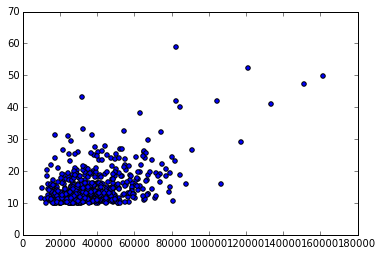

In [28]:
plt.scatter(ibs_sab[ibs_sab["lod"]>10]["length"],ibs_sab[ibs_sab["lod"]>10]["lod"])

In [29]:
ibs_sab[ibs_sab["lod"]>10].corr()

,strd0,strd1,start,end,lod,length
strd0,1.000000,-0.043168,0.021327,0.021285,-0.060441,-0.078772
strd1,-0.043168,1.000000,-0.099801,-0.099772,-0.016722,0.053950
start,0.021327,-0.099801,1.000000,1.000000,0.063416,-0.008624
end,0.021285,-0.099772,1.000000,1.000000,0.063694,-0.008095
lod,-0.060441,-0.016722,0.063416,0.063694,1.000000,0.523384
length,-0.078772,0.053950,-0.008624,-0.008095,0.523384,1.000000


(0, 0.05)

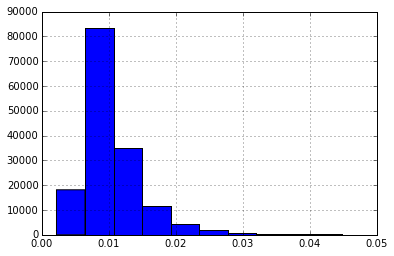

In [25]:
(ibs_sab["length"]*114./139301422).hist(bins=200)
ax = plt.gca()
ax.set_xlim([0,0.05])

In [8]:
pop3_group = ibd_df.groupby(["sp0","sp1"])

In [23]:
df['length'].quantile(0.95)

20988.200000000012

In [99]:
def get_median_len_kb(pop3_group):
    l = pop3_group.apply(lambda df: df['length'].median()).unstack().fillna(0)
    l = (l+l.T)
    l_df = pd.DataFrame(np.tril(l.values),index=l.index,columns=l.columns)
    return (l_df/1000.).applymap(round)

In [53]:
def get_max_len_kb(pop3_group):
    l = pop3_group.apply(lambda df: df['length'].max()).unstack().fillna(0)
    l = (l+l.T)
    l_df = pd.DataFrame(np.tril(l.values),index=l.index,columns=l.columns)
    return (l_df/1000.).applymap(round)

In [54]:
def get_n_shared_per_comparison(pop3_group):
    l = pop3_group.apply(lambda x: len(x)).unstack().fillna(0)
    l = (l+l.T)
    l_df = pd.DataFrame(np.triu(l.values),index=l.index,columns=l.columns)
    vc = mt["pop3"].value_counts()
    #this is the number of individual pairs, makes a small error for diagonal entries
    normalisation = pd.DataFrame(np.outer(vc.values,vc.values)/2,index=vc.index,columns=vc.index)
    return (l_df/normalisation).applymap(round)

In [120]:
ibd_df["c0"] = [s for s in  mt.ix[ibd_df["id0"]]["country"].values]
ibd_df["c1"] = [s for s in  mt.ix[ibd_df["id1"]]["country"].values]

In [122]:
country_group = ibd_df.groupby(["c0","c1"])

In [124]:
l = country_group.apply(lambda x: len(x)).unstack().fillna(0)
l = (l+l.T)
#l = pd.DataFrame(np.triu(l.values),index=l.index,columns=l.columns)
vc = mt["country"].value_counts()
#this is the number of individual pairs, makes a small error for diagonal entries
normalisation = pd.DataFrame(np.outer(vc.values,vc.values)/2,index=vc.index,columns=vc.index)
(l/normalisation).applymap(round)

,Barbados,Botswana,Central African Republic,Ethiopia,Gambia,Ghana,Kenya,Nevis,Saint Kitts,South Africa,Tanzania,Zambia
Barbados,2405,1,8,1,953,723,2,1598,1808,1,1,1
Botswana,1,125,8,3,1,3,46,1,2,177,42,148
Central African Republic,8,8,200,7,8,29,15,15,13,5,7,7
Ethiopia,1,3,7,667,1,2,15,1,1,4,8,5
Gambia,953,1,8,1,1162,693,3,1099,1123,1,2,2
Ghana,723,3,29,2,693,481,4,829,882,2,7,4
Kenya,2,46,15,15,3,4,186,3,3,40,160,54
Nevis,1598,1,15,1,1099,829,3,4160,3151,2,1,2
Saint Kitts,1808,2,13,1,1123,882,3,3151,3477,2,1,2
South Africa,1,177,5,4,1,2,40,2,2,495,27,94


In [ ]:
Conclusion: Central African republic shares more with Ghana than with Gambia -> Signal of migration!?

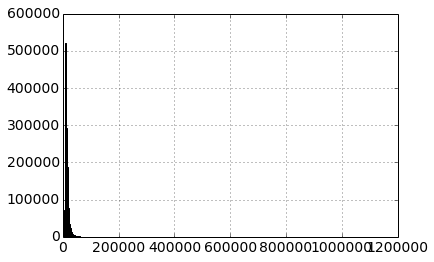

In [127]:
ibd_df["length"].hist(bins=500)

In [129]:
import random

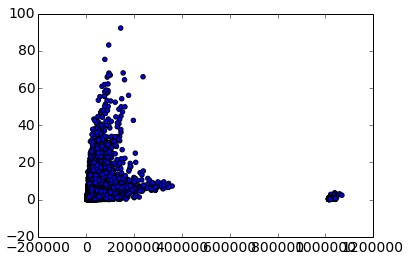

In [128]:
plt.scatter(ibd_df["length"],ibd_df["lod"])

In [131]:
small_df = ibd_df.ix[random.sample(ibd_df.index, 1000)]

In [138]:
country_pair_ls = list(small_df["country"].unique())

/net/gmi.oeaw.ac.at/nordborg/user/hannes.svardal/Documents/Dropbox/Akademisches/lib/python/virtualenvs/ver/lib/python2.7/site-packages/matplotlib/axes.py:4747: UserWarning: No labeled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labeled objects found. "


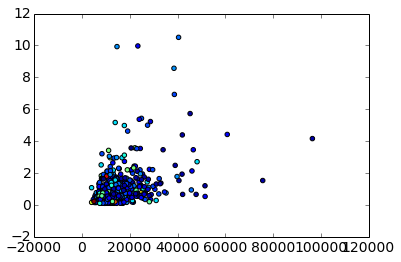

In [141]:
plt.scatter(small_df["length"],small_df["lod"],
            c=small_df["country"].apply(lambda x: country_pair_ls.index(x)*1./len(country_pair_ls)))

plt.legend()